<a href="https://colab.research.google.com/github/IlyaDenisov88/dataenj/blob/main/PySpark/Cache_and_Persist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840625 sha256=c47ed504f891354a9a764ef624c7ff20db9a125ffc678bdf01c6e972e9ed305e
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


# Cache

`cache` — это метод в Apache Spark, который используется для кэширования данных в памяти. Он позволяет избежать повторного выполнения вычислений при повторном доступе к данным. Кэширование может существенно повысить производительность Spark-приложений, особенно если одни и те же данные используются многократно в различных этапах вычислений, то есть чаще всего при join операциях.

Основная логика cache следующая -

* Данные сохраняются в оперативной памяти всех рабочих узлов (executors) кластера.
* При повторном доступе к данным Spark извлекает их из памяти, а не выполняет вычисления заново.
* Метод `cache` помечает DataFrame или RDD для кэширования, но фактически кэширование происходит только при первом вызове действия (action), которое вызывает выполнение вычислений (например, `count`, `collect`, `show`).
* Если данные не помещаются в память, Spark может использовать метод `persist` с соответствующим уровнем хранения (storage level), чтобы сохранить их на диск (но об этом попозже)


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("Cache Example") \
    .getOrCreate()

data = [(i, f"Name_{i % 5}") for i in range(1000)]
df = spark.createDataFrame(data, ["id", "name"])

# Применяем фильтр и кэшируем результат
filtered_df = df.filter(col("id") % 2 == 0).cache()

# Первое действие (action) вызывает выполнение и кэширование
filtered_df.count()  # Это действие выполнит фильтрацию и закэширует результат

# Повторное использование закэшированных данных
filtered_df.show()  # Это действие извлечет данные из кэша и отобразит их

spark.stop()


+---+------+
| id|  name|
+---+------+
|  0|Name_0|
|  2|Name_2|
|  4|Name_4|
|  6|Name_1|
|  8|Name_3|
| 10|Name_0|
| 12|Name_2|
| 14|Name_4|
| 16|Name_1|
| 18|Name_3|
| 20|Name_0|
| 22|Name_2|
| 24|Name_4|
| 26|Name_1|
| 28|Name_3|
| 30|Name_0|
| 32|Name_2|
| 34|Name_4|
| 36|Name_1|
| 38|Name_3|
+---+------+
only showing top 20 rows



У cache только один минус - метод `cache` использует стандартный уровень хранения `MEMORY_ONLY`. Поэтому двинемся в сторону persist. А далее рассмотрим и другие уровни хранения.



# Persist

Метод `persist` в Apache Spark используется для сохранения RDD (Resilient Distributed Dataset) или DataFrame в памяти и/или на диске с различными уровнями хранения (storage levels). В отличие от `cache`, который использует только память для хранения данных, `persist` предоставляет более гибкие опции для управления кэшированием, включая использование дискового пространства и другие стратегии хранения.

Рассмотрим основные задачи persist -

1. `persist` позволяет выбирать различные уровни хранения, такие как память, диск или их комбинация, что помогает эффективно использовать доступные ресурсы кластера.

2. Кэширование данных в памяти или на диске позволяет избежать повторного выполнения дорогостоящих вычислений при многократном доступе к данным, улучшая производительность приложений.

3. Кэширование данных на диск может обеспечить дополнительную надежность, так как данные сохраняются и могут быть восстановлены в случае сбоя узла или других проблем.

Теперь давайте рассмотрим основные уровни хранения, которые можно использовать с persist -

* MEMORY_ONLY: Кэширует данные только в памяти. Если данные не помещаются, они не сохраняются на диск.
* MEMORY_AND_DISK: Кэширует данные в памяти и на диске, если данные не помещаются в память.
* DISK_ONLY: Кэширует данные только на диске.
* MEMORY_ONLY_SER: Кэширует данные в памяти в сериализованном виде. Это уменьшает объем памяти, но увеличивает время доступа.
* MEMORY_AND_DISK_SER: Кэширует данные в памяти и на диске в сериализованном виде.
* OFF_HEAP: Кэширует данные в памяти вне кучи (off-heap), что может уменьшить накладные расходы на сборку мусора (Garbage Collection).

Рассмотрим пример с Memory_And_Disk.



In [4]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("Persist Example") \
    .getOrCreate()

data = [(i, f"Name_{i % 5}") for i in range(1000)]
df = spark.createDataFrame(data, ["id", "name"])

# Применяем фильтр и сохраняем результат с уровнем хранения MEMORY_AND_DISK
filtered_df = df.filter(col("id") % 2 == 0).persist(StorageLevel.MEMORY_AND_DISK)

# Первое действие вызывает выполнение и кэширование
filtered_df.count()  # Это действие выполнит фильтрацию и закэширует результат в памяти и на диске

# Повторное использование закэшированных данных
filtered_df.show()  # Это действие извлечет данные из кэша и отобразит их

spark.stop()


+---+------+
| id|  name|
+---+------+
|  0|Name_0|
|  2|Name_2|
|  4|Name_4|
|  6|Name_1|
|  8|Name_3|
| 10|Name_0|
| 12|Name_2|
| 14|Name_4|
| 16|Name_1|
| 18|Name_3|
| 20|Name_0|
| 22|Name_2|
| 24|Name_4|
| 26|Name_1|
| 28|Name_3|
| 30|Name_0|
| 32|Name_2|
| 34|Name_4|
| 36|Name_1|
| 38|Name_3|
+---+------+
only showing top 20 rows



И также с disk_only.



In [10]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


spark = SparkSession.builder \
    .appName("Persist Example") \
    .getOrCreate()


data = [(i, f"Name_{i % 5}") for i in range(1000)]
df = spark.createDataFrame(data, ["id", "name"])

# Применяем фильтр и сохраняем результат с уровнем хранения DISK_ONLY
filtered_df = df.filter(col("id") % 2 == 0).persist(StorageLevel.DISK_ONLY)


filtered_df.count()  # Это действие выполнит фильтрацию и закэширует результат на диске


filtered_df.show()  # Это действие извлечет данные из кэша и отобразит их



+---+------+
| id|  name|
+---+------+
|  0|Name_0|
|  2|Name_2|
|  4|Name_4|
|  6|Name_1|
|  8|Name_3|
| 10|Name_0|
| 12|Name_2|
| 14|Name_4|
| 16|Name_1|
| 18|Name_3|
| 20|Name_0|
| 22|Name_2|
| 24|Name_4|
| 26|Name_1|
| 28|Name_3|
| 30|Name_0|
| 32|Name_2|
| 34|Name_4|
| 36|Name_1|
| 38|Name_3|
+---+------+
only showing top 20 rows



 Также все работает. Но, возникает логичный вопрос - когда что необходимо использовать?

Давайте разбираться.



**MEMORY_ONLY**

**Описание**: Кэширует данные только в памяти. Если данные не помещаются в память, они не сохраняются на диск.

**Когда использовать**:
- Когда данные небольшие и могут поместиться в память всех узлов.
- Когда нужно минимизировать время доступа к данным.
- Когда допустимо потерять кэшированные данные в случае нехватки памяти.


**MEMORY_AND_DISK**

**Описание**: Кэширует данные в памяти и на диске, если данные не помещаются в память.

**Когда использовать**:
- Когда данные слишком большие для хранения только в памяти.
- Когда важно сохранить данные, даже если они не помещаются в память.
- Когда допустимо более медленное время доступа к данным, сохраненным на диск.


**DISK_ONLY**

**Описание**: Кэширует данные только на диске.

**Когда использовать**:
- Когда данные слишком большие для хранения в памяти.
- Когда приоритетом является сохранение данных, а не скорость доступа к ним.
- Когда узлы имеют ограниченную память, но достаточно места на диске.


**MEMORY_ONLY_SER**

**Описание**: Кэширует данные в памяти в сериализованном виде, что уменьшает объем памяти, но увеличивает время доступа.

**Когда использовать**:
- Когда данные слишком большие для хранения в несериализованном виде.
- Когда доступная память ограничена.
- Когда допустимо большее время доступа из-за необходимости десериализации данных.


**MEMORY_AND_DISK_SER**

**Описание**: Кэширует данные в памяти и на диске в сериализованном виде.

**Когда использовать**:
- Когда данные слишком большие для хранения в памяти в несериализованном виде.
- Когда важно сохранить данные и доступна ограниченная память.
- Когда допустимо большее время доступа из-за необходимости десериализации данных.


**OFF_HEAP**

**Описание**: Кэширует данные в памяти вне кучи (off-heap), что может уменьшить накладные расходы на сборку мусора (Garbage Collection).

**Когда использовать**:
- Когда необходимо минимизировать влияние сборки мусора на производительность.
- Когда приложение требует стабильной и предсказуемой производительности.
- Когда доступна поддержка off-heap памяти.


Такая небольшая подсказка получилась. Но это если научным языком объяснять. Поэтому давайте также опишем когда что применять, исходя из практического опыта.

**Для небольших данных:**

- Используйте MEMORY_ONLY для минимизации времени доступа, если данные полностью помещаются в память.

**Для больших данных:**
- Используйте MEMORY_AND_DISK, если данные не помещаются в память и важно сохранить данные.
- Используйте DISK_ONLY, если память ограничена и приоритетом является сохранение данных.

**Для ограниченной памяти:**
- Используйте MEMORY_ONLY_SER или MEMORY_AND_DISK_SER, если данные слишком большие для хранения в несериализованном виде.

**Для стабильной производительности:**
- Используйте OFF_HEAP, если необходимо минимизировать влияние сборки мусора.

**Для критически важных данных:**
- Рассмотрите использование MEMORY_AND_DISK или DISK_ONLY для обеспечения сохранности данных даже в случае нехватки памяти.


Цитата ответа Артема на фопрос о различиях `cache` и `persist`:
*я не помню точно, но по моему сначала появился cache, потом persist. Как спарк контекст и спарк сессия. А отличия у них нету. В cache не указывается уровень, а в persist указывается.*



In [11]:
sc = spark.sparkContext
rdd = sc.parallelize([1, 2, 3, 4, 5])
rdd.cache()

rdd = sc.parallelize([1, 2, 3, 4, 5])
rdd.persist(StorageLevel.MEMORY_ONLY)

# Останавливаем SparkSession
spark.stop()


# Unpersist

Метод `unpersist` в Apache Spark используется для удаления ранее закэшированных данных из памяти и/или диска. Он отменяет кэширование, освобождая ресурсы, занятые этими данными. Это особенно полезно для управления памятью и ресурсами кластера, когда больше нет необходимости в закэшированных данных.

Задачи, но все же я их распишу.

1. Метод `unpersist` освобождает память и/или диск, занятые закэшированными данными. Это позволяет Spark использовать освободившиеся ресурсы для других задач.

2. Метод `unpersist` может быть применен как к RDD, так и к DataFrame, которые были ранее закэшированы с использованием методов `cache` или `persist`.

3. По умолчанию, `unpersist` выполняет ленивую очистку, то есть данные удаляются только тогда, когда Spark решает, что это необходимо. Однако можно принудительно удалить данные немедленно. Это очень важно знать.

Ну и в заключение пример.



In [12]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


spark = SparkSession.builder \
    .appName("Unpersist Example") \
    .getOrCreate()


data = [(i, f"Name_{i % 5}") for i in range(1000)]
df = spark.createDataFrame(data, ["id", "name"])

# Применяем фильтр и кэшируем результат
filtered_df = df.filter(col("id") % 2 == 0).cache()

# Выполняем действие, чтобы закэшировать данные
filtered_df.count()

# Освобождаем закэшированные данные
filtered_df.unpersist()


spark.stop()

# Практика

In [5]:
import time
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CacheAndPersist").getOrCreate()

data = [(i, i*2) for i in range(1, 100000)] # список
df = spark.createDataFrame(data, ["num", "double"]) # df из списка

# функция для сравнения времени кеширования при использовании cache() и persist()
def measure_time(action, rdd_or_df): # операция и данные
  start_time = time.time()
  rdd_or_df.count() # действие к датафрейму (чтобы кеширование сделалось)
  print(f"Время выполнения для {action}: {time.time() - start_time:.4f} секунд")

# Архивация данных, чтобы потом быстро получать к ним доступ
df_cached = df.cache()
measure_time("cache", df_cached)

df_cached.unpersist() # очистить  оперативную память от кеша

df_persisted = df.persist() # по умолчинию MEMORY_AND_DISK
measure_time("persist", df_persisted)

df_persisted.unpersist()
spark.stop()

Время выполнения для cache: 1.5944 секунд
Время выполнения для persist: 1.0087 секунд


- в данном случае persist по времени быстрее
- на самом деле, чем больше данных, тем больше выигрывает cache (тк он не работает с диском).


In [ ]:
# cache - только оперативная память
# persist - оперативная память + диск

## Что когда использовать на практике

- Когда данные не помещаются в ОП - persist
- Когда помещаются - использовать cache
- Вместе - при сложных join в persist - результаты и большие таблицы, в cache - маленькие таблицы

# Дз: что быстрее при чтении Cache или Persist

Сработает ли также хорошо persist на чтение?

In [20]:
import time
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("CacheAndPersist").getOrCreate()

data = [(i, i*2) for i in range(1, 10000000)] # список
df = spark.createDataFrame(data, ["num", "double"]) # df из списка

# функция для сравнения времени кеширования при использовании cache() и persist()
def measure_100times_read_time(action, rdd_or_df): # операция и данные
  rdd_or_df.count() # действие, чтобы кеширование не учитывалось во время чтения
  read_start_time = time.time()
  for i in range(100):
    rdd_or_df.show()  # Это действие извлечет данные из кэша и отобразит их
  print(f"Время выполнения для {action}: {time.time() - read_start_time:.4f} секунд")

# Архивация данных, чтобы потом быстро получать к ним доступ
df_cached = df.cache()
measure_time("cache", df_cached)

df_cached.unpersist() # очистить  оперативную память от кеша

df_persisted = df.persist() # по умолчинию MEMORY_AND_DISK
measure_time("persist", df_persisted)

df_persisted.unpersist()

spark.stop()

Время выполнения для cache: 21.7299 секунд
Время выполнения для persist: 21.1507 секунд


Видим, что для многократного чтения результат сопоставим

Если сравнить чисто время чтения данных без выполнения кеширования на удивление быстрее работает persist

In [17]:
# Проверка использования оперативки и диска
import psutil

# Получение общей информации о памяти
mem = psutil.virtual_memory()
print(f"Общая память: {mem.total / (1024 * 1024):.2f} MB")
print(f"Используется: {mem.used / (1024 * 1024):.2f} MB")
print(f"Свободно: {mem.available / (1024 * 1024):.2f} MB")
print(f"Процент использования: {mem.percent}%")

# Получение информации о диске
disk = psutil.disk_usage('/')
print(f"Общий объем диска: {disk.total / (1024 * 1024 * 1024):.2f} GB")
print(f"Используется: {disk.used / (1024 * 1024 * 1024):.2f} GB")
print(f"Свободно: {disk.free / (1024 * 1024 * 1024):.2f} GB")
print(f"Процент использования: {disk.percent}%")

Общая память: 12978.96 MB
Используется: 3386.64 MB
Свободно: 9270.00 MB
Процент использования: 28.6%
Общий объем диска: 107.72 GB
Используется: 37.35 GB
Свободно: 70.35 GB
Процент использования: 34.7%


(выше отобразились характеристики гугловской машины)

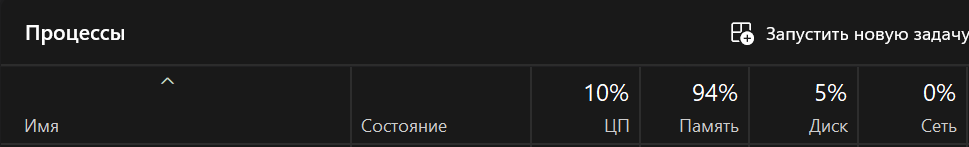

Ну да, нагрузка на оперативу немаленькая...

В общем в теории cache быстрее на чтение, persist - хорошо, когда мало оперативы и нужно че-то подсохранить на диск

# Тестовые вопросы

1. Что произойдет, если вы вызовете cache() на DataFrame, который уже закэширован с использованием persist(StorageLevel.DISK_ONLY)?

- **Ответ**: DataFrame останется закэшированным на диске, так как persist имеет приоритет над cache.

2. Какой уровень хранения следует использовать, если необходимо кэшировать данные для минимизации влияния сборки мусора на производительность?
- OFF_HEAP




3. Какое поведение ожидается при вызове unpersist() на DataFrame, который был закэширован с использованием persist(StorageLevel.MEMORY_AND_DISK)?

- Данные будут удалены из памяти и с диска.
